### Fashion-MNIST 

In [ ]:
from tensorflow.keras import utils
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist

In [ ]:
!pip install hyperas
!pip install hyperopt

In [ ]:

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

In [ ]:

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=12345)

In [ ]:
print(X_train.shape[0],X_val.shape[0])

48000 12000


In [ ]:
X_train = X_train.reshape(48000, 784)
X_val = X_val.reshape(12000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

In [ ]:
# if we observe the above matrix each cell is having a value between 0-255
# before we move to apply machine learning algorithms lets try to normalize the data
# X => (X - Xmin)/(Xmax-Xmin) = X/255

X_train = X_train/255
X_test = X_test/255
X_val = X_val/255


In [ ]:
# np is numpy
# lets convert this into a 10 dimensional vector
# ex: consider an image is of class 5 convert it into 5 => [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
# this conversion needed for MLPs 
nb_classes = 10 
Y_train = utils.to_categorical(y_train, nb_classes)
Y_val = utils.to_categorical(y_val, nb_classes)
Y_test = utils.to_categorical(y_test, nb_classes)

## Base Model

<h2>  Softmax classifier  </h2>

In [ ]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation, Dropout

In [ ]:
# some model parameters

output_dim = 10
input_dim = X_train.shape[1]

batch_size = 128 
nb_epoch = 20

In [ ]:
# start building a model
model = Sequential(Dense(output_dim, input_dim=input_dim, activation='softmax'))
model.compile(optimizer='sgd',
 loss='categorical_crossentropy',
 metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_135 (Dense)            (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, Y_train, steps_per_epoch=500, epochs=nb_epoch, verbose=1, validation_data=(X_val, Y_val)) 


Epoch 1/20
500/500 [==============================] - 2s 3ms/step - loss: 1.4597 - accuracy: 0.5662 - val_loss: 0.8348 - val_accuracy: 0.7364
Epoch 2/20
500/500 [==============================] - 1s 3ms/step - loss: 0.7959 - accuracy: 0.7481 - val_loss: 0.7150 - val_accuracy: 0.7732
Epoch 3/20
500/500 [==============================] - 1s 3ms/step - loss: 0.7020 - accuracy: 0.7725 - val_loss: 0.6574 - val_accuracy: 0.7944
Epoch 4/20
500/500 [==============================] - 1s 3ms/step - loss: 0.6478 - accuracy: 0.7914 - val_loss: 0.6203 - val_accuracy: 0.8035
Epoch 5/20
500/500 [==============================] - 1s 3ms/step - loss: 0.6172 - accuracy: 0.7996 - val_loss: 0.5954 - val_accuracy: 0.8086
Epoch 6/20
500/500 [==============================] - 1s 3ms/step - loss: 0.5917 - accuracy: 0.8074 - val_loss: 0.5763 - val_accuracy: 0.8173
Epoch 7/20
500/500 [==============================] - 1s 3ms/step - loss: 0.5712 - accuracy: 0.8114 - val_loss: 0.5607 - val_accuracy: 0.8204
Epoch 

In [ ]:
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.5135301351547241
Test accuracy: 0.8269000053405762


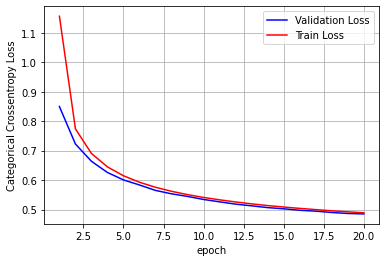

In [ ]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

<b>Base Model has given an accuracy of 82%, but to improve the model we need to know about which are the hyper-parameters we can tune in our dense network</b>

In [ ]:
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

In [ ]:
def data():
    import keras
    from tensorflow.keras import utils as np_utils
    from tensorflow.keras.layers import Dense, Activation, Dropout
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    X_train, X_val, y_train, y_val = train_test_split(X_train,    y_train, test_size=0.2, random_state=12345)
    X_train = X_train.reshape(48000, 784)
    X_val = X_val.reshape(12000, 784)
    X_train = X_train.astype('float32')
    X_val = X_val.astype('float32')
    X_train /= 255
    X_val /= 255
    nb_classes = 10
    Y_train = np_utils.to_categorical(y_train, nb_classes)
    Y_val = np_utils.to_categorical(y_val, nb_classes)
    return X_train, Y_train, X_val, Y_val

In [ ]:
def model(X_train, Y_train, X_val, Y_val):
    
    model = Sequential()
    
    model.add(Dense({{choice([128, 256, 512, 1024])}}, input_shape=(784,)))
    model.add(Activation({{choice(['relu', 'sigmoid'])}}))
    model.add(Dropout({{uniform(0, 1)}}))
    model.add(Dense({{choice([128, 256, 512, 1024])}}))
    model.add(Activation({{choice(['relu', 'sigmoid'])}}))
    model.add(Dropout({{uniform(0, 1)}}))


    if {{choice(['two', 'three'])}} == 'three':
        model.add(Dense({{choice([128, 256, 512, 1024])}}))
        model.add(Activation({{choice(['relu', 'sigmoid'])}}))
        model.add(Dropout({{uniform(0, 1)}}))
        
    model.add(Dense(10))
    model.add(Activation('softmax'))
    adam = keras.optimizers.Adam(lr={{choice([10**-3, 10**-2, 10**-1])}})
    rmsprop = keras.optimizers.RMSprop(lr={{choice([10**-3, 10**-2, 10**-1])}})
    sgd = keras.optimizers.SGD(lr={{choice([10**-3, 10**-2, 10**-1])}})
   
    choiceval = {{choice(['adam', 'sgd', 'rmsprop'])}}
    if choiceval == 'adam':
        optim = adam
    elif choiceval == 'rmsprop':
        optim = rmsprop
    else:
        optim = sgd
        
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=optim)
    model.fit(X_train, Y_train,
              batch_size={{choice([128,256,512])}},
              epochs=20,
              verbose=2,
              validation_data=(X_val, Y_val))
    score, acc = model.evaluate(X_val, Y_val, verbose=0)
    print('Validation accuracy:', acc)
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}

In [ ]:
# Install the PyDrive wrapper & import libraries.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [ ]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Copy/download the file
fid = drive.ListFile({'q':"title='fashionMNIST.ipynb'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('fashionMNIST.ipynb')

In [ ]:
X_train, Y_train, X_val, Y_val = data()
best_run, best_model = optim.minimize(model=model,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=30,
                                      trials=Trials(),
                                      notebook_name='/fashionMNIST')

>>> Imports:
#coding=utf-8

try:
    from tensorflow.keras import utils
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    from tensorflow.keras.datasets import fashion_mnist
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import time
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from tensorflow.keras.models import Sequential
except:
    pass

try:
    from tensorflow.keras.layers import Dense, Activation, Dropout
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

try:
    from hyperas import optim
except:
    pass

try:
    from hyperas.distributions import choice, uniform
except:
    pass

try:
    from tensorflow.keras import utils
except:
    pass

try:
    from tensorflow.keras.layers import Dense, Activation, Dropout
except:
    pass

try:
    from pydrive.auth import Googl

In [ ]:
    print("Evalutation of best performing model:")
    print(best_model.evaluate(X_test, Y_test))
    print("Best performing model chosen hyper-parameters:")
    print(best_run)

Evalutation of best performing model:
313/313 [==============================] - 1s 2ms/step - loss: 0.3384 - accuracy: 0.8910
[0.33840444684028625, 0.890999972820282]
Best performing model chosen hyper-parameters:
{'Activation': 0, 'Activation_1': 0, 'Activation_2': 1, 'Dense': 2, 'Dense_1': 3, 'Dense_2': 2, 'Dropout': 0.002343401291026753, 'Dropout_1': 0.6759984371956214, 'Dropout_2': 1, 'Dropout_3': 0.0032498967209000917, 'batch_size': 1, 'choiceval': 0, 'lr': 0, 'lr_1': 0, 'lr_2': 2}


In [ ]:
from keras.layers.normalization import BatchNormalization
model = Sequential([
    Dense(512, input_shape=(784,), activation='relu'),
    Dropout(0.002),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.675),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.003),
    Dense(10, activation='softmax')
])
model.compile(optimizer='adam',
 loss='categorical_crossentropy',
 metrics=['accuracy'])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2

In [ ]:
history = model.fit(X_train, Y_train, steps_per_epoch=500, epochs=20, verbose=1, validation_data=(X_val, Y_val)) 

Epoch 1/20
500/500 [==============================] - 4s 4ms/step - loss: 0.7515 - accuracy: 0.7440 - val_loss: 0.4813 - val_accuracy: 0.8303
Epoch 2/20
500/500 [==============================] - 2s 4ms/step - loss: 0.4410 - accuracy: 0.8409 - val_loss: 0.3933 - val_accuracy: 0.8617
Epoch 3/20
500/500 [==============================] - 2s 4ms/step - loss: 0.3802 - accuracy: 0.8602 - val_loss: 0.3746 - val_accuracy: 0.8662
Epoch 4/20
500/500 [==============================] - 2s 4ms/step - loss: 0.3574 - accuracy: 0.8676 - val_loss: 0.3870 - val_accuracy: 0.8680
Epoch 5/20
500/500 [==============================] - 2s 4ms/step - loss: 0.3321 - accuracy: 0.8745 - val_loss: 0.3684 - val_accuracy: 0.8664
Epoch 6/20
500/500 [==============================] - 2s 4ms/step - loss: 0.3179 - accuracy: 0.8837 - val_loss: 0.3110 - val_accuracy: 0.8896
Epoch 7/20
500/500 [==============================] - 2s 4ms/step - loss: 0.3047 - accuracy: 0.8860 - val_loss: 0.3323 - val_accuracy: 0.8820
Epoch 

In [ ]:
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.3470429480075836
Test accuracy: 0.8840000033378601


By chhosing the best parameters